<a href="https://colab.research.google.com/github/KattaGowri/HospitalManegmentSystem.io/blob/main/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2 align="left"><font color=#ff6200>CUSTOMER SEGMENTATION</font></h2>

<a id="setup"></a>
# <p style="background-color: #ff6200; font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Step 1 | Setup and Initialization</p>

Step 1.1 |  Importing Necessary Libraries

In [54]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter

%matplotlib inline

Step 1.2 | Loading the Dataset

In [2]:
df = pd.read_csv('/content/data.csv', encoding="ISO-8859-1")


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Step 2 | Dataset Overview

In [4]:
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2.0,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6.0,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6.0,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6.0,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32.0,12/1/2010 8:34,1.69,13047.0,United Kingdom


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12462 entries, 0 to 12461
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    12462 non-null  object 
 1   StockCode    12462 non-null  object 
 2   Description  12417 non-null  object 
 3   Quantity     12461 non-null  float64
 4   InvoiceDate  12461 non-null  object 
 5   UnitPrice    12461 non-null  float64
 6   CustomerID   8956 non-null   float64
 7   Country      12461 non-null  object 
dtypes: float64(3), object(5)
memory usage: 779.0+ KB


<div style="border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:120%; text-align:left">
    
Now, I am going to generate summary statistics to gain initial insights into the data distribution:

In [6]:
# Summary statistics for categorical variables
df.describe(include='object').T

,count,unique,top,freq
InvoiceNo,12462,585,537237,597
StockCode,12462,2168,22632,75
Description,12417,2136,HAND WARMER SCOTTY DOG DESIGN,72
InvoiceDate,12461,504,12/6/2010 9:58,597
Country,12461,15,United Kingdom,11806


Step 3 |  Data Cleaning & Transformation

Step 3.1 | Handling Missing Values

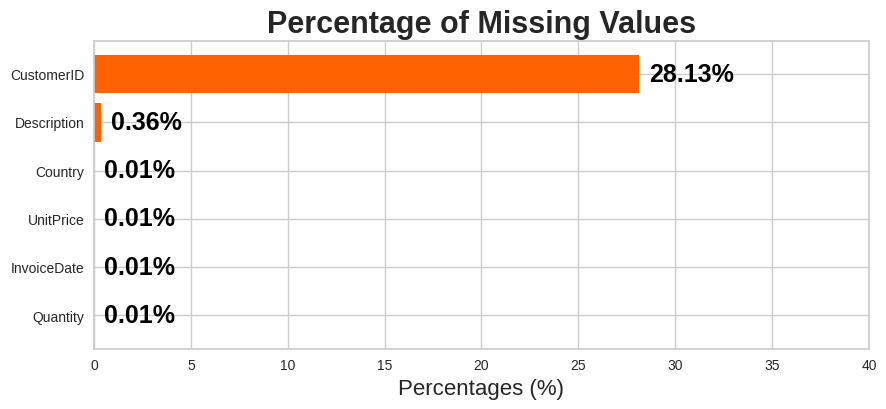

In [7]:
# Calculating the percentage of missing values for each column
missing_data = df.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100

# Prepare values
missing_percentage.sort_values(ascending=True, inplace=True)

# Plot the barh chart
fig, ax = plt.subplots(figsize=(10, 4))
ax.barh(missing_percentage.index, missing_percentage, color='#ff6200')

for i, (value, name) in enumerate(zip(missing_percentage, missing_percentage.index)):
    ax.text(value+0.5, i, f"{value:.2f}%", ha='left', va='center', fontweight='bold', fontsize=18, color='black')

ax.set_xlim([0, 40])
plt.title("Percentage of Missing Values", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()

In [8]:
# Extracting rows with missing values in 'CustomerID' or 'Description' columns
df[df['CustomerID'].isnull() | df['Description'].isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56.0,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1.0,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2.0,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4.0,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2.0,12/1/2010 14:32,1.66,NaN,United Kingdom


In [9]:
# Removing rows with missing values in 'CustomerID' and 'Description' columns
df = df.dropna(subset=['CustomerID', 'Description'])

In [10]:
# Verifying the removal of missing values
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


Step 3.2 | Handling Duplicates

In [11]:
# Finding duplicate rows (keeping all instances)
duplicate_rows = df[df.duplicated(keep=False)]

# Sorting the data by certain columns to see the duplicate rows next to each other
duplicate_rows_sorted = duplicate_rows.sort_values(by=['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Quantity'])

# Displaying the first 10 records
duplicate_rows_sorted.head(10)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1.0,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1.0,12/1/2010 11:45,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1.0,12/1/2010 11:45,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1.0,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1.0,12/1/2010 11:45,2.10,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1.0,12/1/2010 11:45,2.10,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1.0,12/1/2010 11:45,2.95,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1.0,12/1/2010 11:45,2.95,17908.0,United Kingdom
578,536412,21448,12 DAISY PEGS IN WOOD BOX,1.0,12/1/2010 11:49,1.65,17920.0,United Kingdom
598,536412,21448,12 DAISY PEGS IN WOOD BOX,1.0,12/1/2010 11:49,1.65,17920.0,United Kingdom


In [12]:
# Displaying the number of duplicate rows
print(f"The dataset contains {df.duplicated().sum()} duplicate rows that need to be removed.")

# Removing duplicate rows
df.drop_duplicates(inplace=True)

The dataset contains 236 duplicate rows that need to be removed.


In [13]:
# Getting the number of rows in the dataframe
df.shape[0]

8720

Step 3.3 | Cancelled Transactions

In [14]:
# Filter out the rows with InvoiceNo starting with "C" and create a new column indicating the transaction status
df['Transaction_Status'] = np.where(df['InvoiceNo'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')

# Analyze the characteristics of these rows (considering the new column)
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancelled_transactions.describe().drop('CustomerID', axis=1)

,Quantity,UnitPrice
count,107.000000,107.000000
mean,-101.485981,5.160748
std,904.196259,5.431121
min,-9360.000000,0.030000
25%,-6.000000,1.650000
50%,-2.000000,2.950000
75%,-1.000000,7.800000
max,-1.000000,29.290000


In [15]:
# Finding the percentage of cancelled transactions
cancelled_percentage = (cancelled_transactions.shape[0] / df.shape[0]) * 100

# Printing the percentage of cancelled transactions
print(f"The percentage of cancelled transactions in the dataset is: {cancelled_percentage:.2f}%")

The percentage of cancelled transactions in the dataset is: 1.23%


Step 3.4 | StockCode Analysis

In [16]:
# Finding the number of unique stock codes
unique_stock_codes = df['StockCode'].nunique()

# Printing the number of unique stock codes
print(f"The number of unique stock codes in the dataset is: {unique_stock_codes}")

The number of unique stock codes in the dataset is: 1797


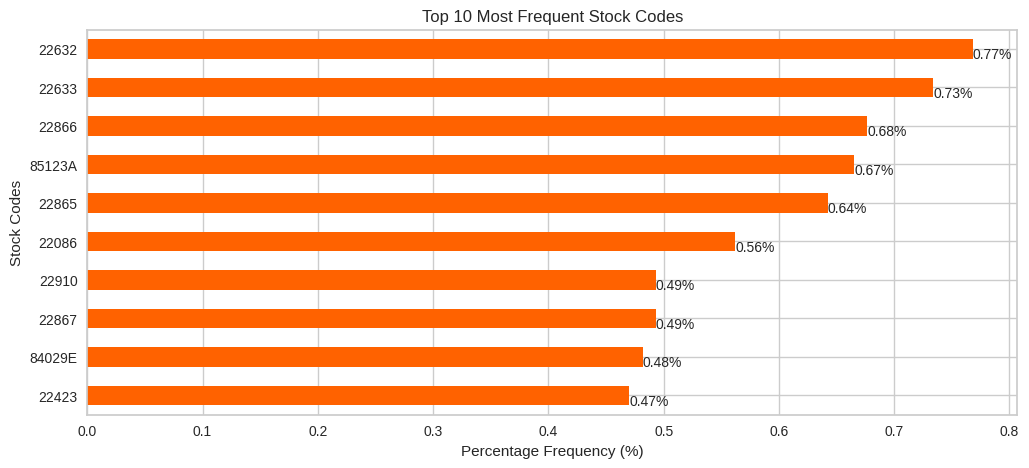

In [17]:
# Finding the top 10 most frequent stock codes
top_10_stock_codes = df['StockCode'].value_counts(normalize=True).head(10) * 100

# Plotting the top 10 most frequent stock codes
plt.figure(figsize=(12, 5))
top_10_stock_codes.plot(kind='barh', color='#ff6200')

# Adding the percentage frequency on the bars
for index, value in enumerate(top_10_stock_codes):
    plt.text(value, index+0.25, f'{value:.2f}%', fontsize=10)

plt.title('Top 10 Most Frequent Stock Codes')
plt.xlabel('Percentage Frequency (%)')
plt.ylabel('Stock Codes')
plt.gca().invert_yaxis()
plt.show()

In [18]:
# Finding the number of numeric characters in each unique stock code
unique_stock_codes = df['StockCode'].unique()
numeric_char_counts_in_unique_codes = pd.Series(unique_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()
print(numeric_char_counts_in_unique_codes)

5    1792
0       4
1       1
Name: count, dtype: int64


Step 3.5 | Description Column

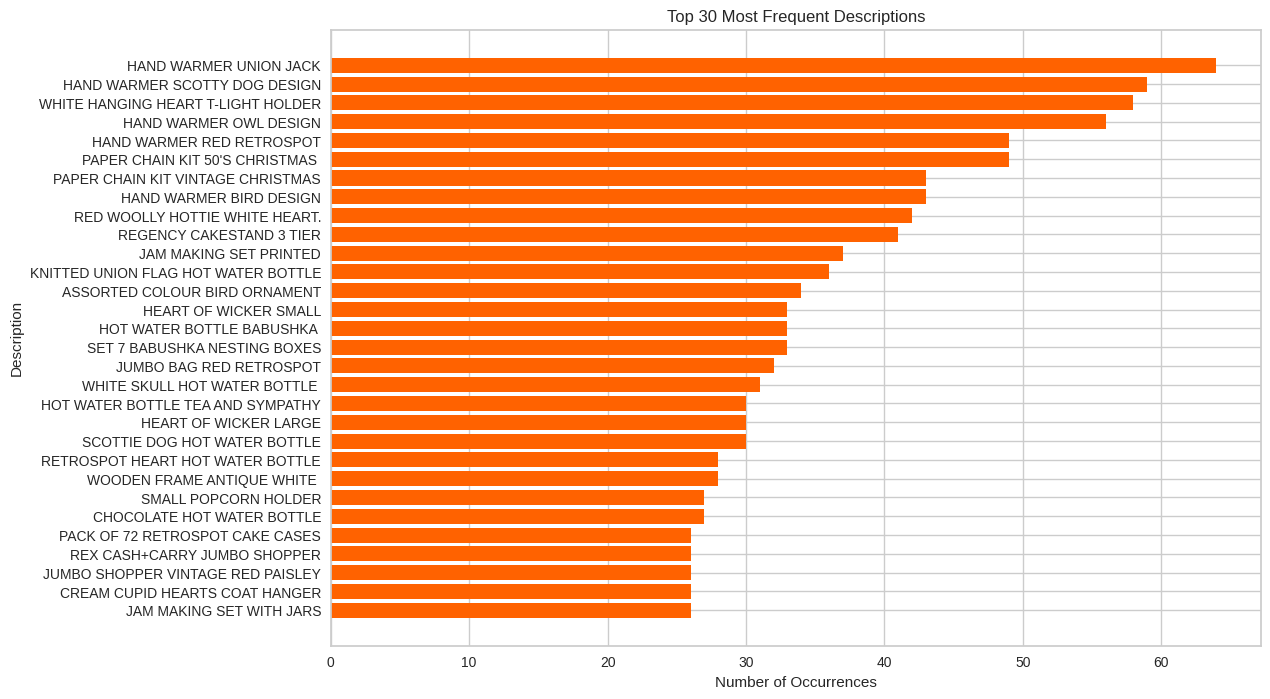

In [19]:
# Calculate the occurrence of each unique description and sort them
description_counts = df['Description'].value_counts()

# Get the top 30 descriptions
top_30_descriptions = description_counts[:30]

# Plotting
plt.figure(figsize=(12,8))
plt.barh(top_30_descriptions.index[::-1], top_30_descriptions.values[::-1], color='#ff6200')

# Adding labels and title
plt.xlabel('Number of Occurrences')
plt.ylabel('Description')
plt.title('Top 30 Most Frequent Descriptions')

# Show the plot
plt.show()

In [20]:
# Find unique descriptions containing lowercase characters
lowercase_descriptions = df['Description'].unique()
lowercase_descriptions = [desc for desc in lowercase_descriptions if any(char.islower() for char in desc)]

# Print the unique descriptions containing lowercase characters
print("The unique descriptions containing lowercase characters are:")
print("-"*60)
for desc in lowercase_descriptions:
    print(desc)

The unique descriptions containing lowercase characters are:
------------------------------------------------------------
Discount
BAG 500g SWIRLY MARBLES
POLYESTER FILLER PAD 45x45cm
POLYESTER FILLER PAD 45x30cm
POLYESTER FILLER PAD 40x40cm
FRENCH BLUE METAL DOOR SIGN No
Manual
BAG 250g SWIRLY MARBLES
BAG 125g SWIRLY MARBLES
3 TRADITIONAl BISCUIT CUTTERS  SET
Bank Charges
NUMBER TILE COTTAGE GARDEN No
FOLK ART GREETING CARD,pack/12
ESSENTIAL BALM 3.5g TIN IN ENVELOPE


Step 3.6 |Zero Unit Prices

In [21]:
df['UnitPrice'].describe()

,UnitPrice
count,8720.000000
mean,3.114447
std,4.926037
min,0.000000
25%,1.250000
50%,2.100000
75%,3.750000
max,295.000000


In [22]:
df[df['UnitPrice']==0].describe()[['Quantity']]

,Quantity
count,1.0
mean,1.0
std,NaN
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


In [23]:
# Removing records with a unit price of zero to avoid potential data entry errors
df = df[df['UnitPrice'] > 0]

In [24]:
df.shape

(8719, 9)

Step 3.7 | Outlier

In [25]:
# Resetting the index of the cleaned dataset
df.reset_index(drop=True, inplace=True)

In [26]:
# Getting the number of rows in the dataframe
df.shape[0]

8719

Step 4 | Feature Engineering

Step 4.1 | RFM Features

Step 4.1.1 | Recency (R)

In [27]:
# Convert InvoiceDate to datetime type
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Convert InvoiceDate to datetime and extract only the date
df['InvoiceDay'] = df['InvoiceDate'].dt.date

# Find the most recent purchase date for each customer
customer_data = df.groupby('CustomerID')['InvoiceDay'].max().reset_index()

# Find the most recent date in the entire dataset
most_recent_date = df['InvoiceDay'].max()

# Convert InvoiceDay to datetime type before subtraction
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate the number of days since the last purchase for each customer
customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days

# Remove the InvoiceDay column
customer_data.drop(columns=['InvoiceDay'], inplace=True)

<div style="border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:120%; text-align:left">
    
Now, __customer_data__ dataframe contains the __`Days_Since_Last_Purchase`__ feature:

In [28]:
customer_data.head()

,CustomerID,Days_Since_Last_Purchase
0,12395.0,3
1,12427.0,3
2,12431.0,5
3,12433.0,5
4,12471.0,4


Step 4.1.2 | Frequency (F)

In [29]:
# Calculate the total number of transactions made by each customer
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
total_transactions.rename(columns={'InvoiceNo': 'Total_Transactions'}, inplace=True)

# Calculate the total number of products purchased by each customer
total_products_purchased = df.groupby('CustomerID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns={'Quantity': 'Total_Products_Purchased'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_transactions, on='CustomerID')
customer_data = pd.merge(customer_data, total_products_purchased, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased
0,12395.0,3,1,528.0
1,12427.0,3,1,79.0
2,12431.0,5,1,107.0
3,12433.0,5,1,1852.0
4,12471.0,4,1,-2.0


Step 4.1.3 | Monetary (M)

In [30]:
# Calculate the total spend by each customer
df['Total_Spend'] = df['UnitPrice'] * df['Quantity']
total_spend = df.groupby('CustomerID')['Total_Spend'].sum().reset_index()

# Calculate the average transaction value for each customer
average_transaction_value = total_spend.merge(total_transactions, on='CustomerID')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_spend, on='CustomerID')
customer_data = pd.merge(customer_data, average_transaction_value[['CustomerID', 'Average_Transaction_Value']], on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value
0,12395.0,3,1,528.0,346.10,346.10
1,12427.0,3,1,79.0,303.50,303.50
2,12431.0,5,1,107.0,358.25,358.25
3,12433.0,5,1,1852.0,1919.14,1919.14
4,12471.0,4,1,-2.0,-17.00,-17.00


Step 4.2 | Product Behaviour

In [31]:
# Calculate the number of unique products purchased by each customer
unique_products_purchased = df.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_products_purchased.rename(columns={'StockCode': 'Unique_Products_Purchased'}, inplace=True)

# Merge the new feature into the customer_data dataframe
customer_data = pd.merge(customer_data, unique_products_purchased, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased
0,12395.0,3,1,528.0,346.10,346.10,12
1,12427.0,3,1,79.0,303.50,303.50,10
2,12431.0,5,1,107.0,358.25,358.25,14
3,12433.0,5,1,1852.0,1919.14,1919.14,73
4,12471.0,4,1,-2.0,-17.00,-17.00,1


Step 4.3 | Behavioral Features

In [32]:
# Extract day of week and hour from InvoiceDate
df['Day_Of_Week'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour

# Calculate the average number of days between consecutive purchases
days_between_purchases = df.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)

# Find the favorite shopping day of the week
favorite_shopping_day = df.groupby(['CustomerID', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Day_Of_Week']]

# Find the favorite shopping hour of the day
favorite_shopping_hour = df.groupby(['CustomerID', 'Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Hour']]

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, average_days_between_purchases, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_hour, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour
0,12395.0,3,1,528.0,346.10,346.10,12,0.000000,4,16
1,12427.0,3,1,79.0,303.50,303.50,10,0.000000,4,10
2,12431.0,5,1,107.0,358.25,358.25,14,0.000000,2,10
3,12433.0,5,1,1852.0,1919.14,1919.14,73,0.000000,2,13
4,12472.0,1,2,932.0,1509.00,754.50,77,0.048193,6,14


Step 4.4 | Geographic Features

In [33]:
df['Country'].value_counts(normalize=True).head()

,proportion
Country,
United Kingdom,0.926253
Germany,0.022365
EIRE,0.015254
France,0.012157
Norway,0.008373


In [34]:
# Group by CustomerID and Country to get the number of transactions per country for each customer
customer_country = df.groupby(['CustomerID', 'Country']).size().reset_index(name='Number_of_Transactions')

# Get the country with the maximum number of transactions for each customer (in case a customer has transactions from multiple countries)
customer_main_country = customer_country.sort_values('Number_of_Transactions', ascending=False).drop_duplicates('CustomerID')

# Create a binary column indicating whether the customer is from the UK or not
customer_main_country['Is_UK'] = customer_main_country['Country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)

# Merge this data with our customer_data dataframe
customer_data = pd.merge(customer_data, customer_main_country[['CustomerID', 'Is_UK']], on='CustomerID', how='left')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK
0,12395.0,3,1,528.0,346.10,346.10,12,0.000000,4,16,0
1,12427.0,3,1,79.0,303.50,303.50,10,0.000000,4,10,0
2,12431.0,5,1,107.0,358.25,358.25,14,0.000000,2,10,0
3,12433.0,5,1,1852.0,1919.14,1919.14,73,0.000000,2,13,0
4,12472.0,1,2,932.0,1509.00,754.50,77,0.048193,6,14,0


In [35]:
# Display feature distribution
customer_data['Is_UK'].value_counts()

,count
Is_UK,
1,318
0,27


Step 4.5 | Cancellation Insights

In [36]:
# Calculate the total number of transactions made by each customer
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

# Calculate the number of cancelled transactions for each customer
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancellation_frequency = cancelled_transactions.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
cancellation_frequency.rename(columns={'InvoiceNo': 'Cancellation_Frequency'}, inplace=True)

# Merge the Cancellation Frequency data into the customer_data dataframe
customer_data = pd.merge(customer_data, cancellation_frequency, on='CustomerID', how='left')

# Replace NaN values with 0 (for customers who have not cancelled any transaction)
customer_data['Cancellation_Frequency'].fillna(0, inplace=True)

# Calculate the Cancellation Rate
customer_data['Cancellation_Rate'] = customer_data['Cancellation_Frequency'] / total_transactions['InvoiceNo']

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate
0,12395.0,3,1,528.0,346.10,346.10,12,0.000000,4,16,0,0.0,0.0
1,12427.0,3,1,79.0,303.50,303.50,10,0.000000,4,10,0,0.0,0.0
2,12431.0,5,1,107.0,358.25,358.25,14,0.000000,2,10,0,0.0,0.0
3,12433.0,5,1,1852.0,1919.14,1919.14,73,0.000000,2,13,0,0.0,0.0
4,12472.0,1,2,932.0,1509.00,754.50,77,0.048193,6,14,0,1.0,1.0


In [37]:
# Changing the data type of 'CustomerID' to string as it is a unique identifier and not used in mathematical operations
customer_data['CustomerID'] = customer_data['CustomerID'].astype(str)

# Convert data types of columns to optimal types
customer_data = customer_data.convert_dtypes()

In [38]:
customer_data.head(10)

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate
0,12395.0,3,1,528,346.1,346.1,12,0.0,4,16,0,0,0.0
1,12427.0,3,1,79,303.5,303.5,10,0.0,4,10,0,0,0.0
2,12431.0,5,1,107,358.25,358.25,14,0.0,2,10,0,0,0.0
3,12433.0,5,1,1852,1919.14,1919.14,73,0.0,2,13,0,0,0.0
4,12472.0,1,2,932,1509.0,754.5,77,0.048193,6,14,0,1,1.0
5,12557.0,3,1,400,620.0,620.0,5,0.0,4,12,0,0,0.0
6,12567.0,1,1,611,1526.92,1526.92,63,0.0,6,11,0,0,0.0
7,12583.0,5,1,449,855.86,855.86,20,0.0,2,8,0,0,0.0
8,12600.0,3,1,31,76.5,76.5,2,0.0,4,12,0,0,0.0
9,12647.0,1,2,90,372.0,186.0,17,0.0,6,14,0,0,0.0


In [39]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerID                      345 non-null    string 
 1   Days_Since_Last_Purchase        345 non-null    Int64  
 2   Total_Transactions              345 non-null    Int64  
 3   Total_Products_Purchased        345 non-null    Int64  
 4   Total_Spend                     345 non-null    Float64
 5   Average_Transaction_Value       345 non-null    Float64
 6   Unique_Products_Purchased       345 non-null    Int64  
 7   Average_Days_Between_Purchases  345 non-null    Float64
 8   Day_Of_Week                     345 non-null    Int32  
 9   Hour                            345 non-null    Int32  
 10  Is_UK                           345 non-null    Int64  
 11  Cancellation_Frequency          345 non-null    Int64  
 12  Cancellation_Rate               345 

<div style="border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:120%; text-align:left">
    
Let's review the descriptions of the columns in our newly created `customer_data` dataset:

<div style="border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:120%; text-align:left">

We've done a great job so far! We have created a dataset that focuses on our customers, using a variety of new features that give us a deeper understanding of their buying patterns and preferences.

Now that our dataset is ready, we can move on to the next steps of our project. This includes looking at our data more closely to find any patterns or trends, making sure our data is in the best shape by checking for and handling any outliers, and preparing our data for the clustering process. All of these steps will help us build a strong foundation for creating our customer segments and, eventually, a personalized recommendation system.

Step 5 | Outlier Detection and Treatment

In [40]:
# Initializing the IsolationForest model with a contamination parameter of 0.05
model = IsolationForest(contamination=0.05, random_state=0)

# Fitting the model on our dataset (converting DataFrame to NumPy to avoid warning)
customer_data['Outlier_Scores'] = model.fit_predict(customer_data.iloc[:, 1:].to_numpy())

# Creating a new column to identify outliers (1 for inliers and -1 for outliers)
customer_data['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_data['Outlier_Scores']]

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Outlier_Scores,Is_Outlier
0,12395.0,3,1,528,346.1,346.1,12,0.0,4,16,0,0,0.0,1,0
1,12427.0,3,1,79,303.5,303.5,10,0.0,4,10,0,0,0.0,1,0
2,12431.0,5,1,107,358.25,358.25,14,0.0,2,10,0,0,0.0,1,0
3,12433.0,5,1,1852,1919.14,1919.14,73,0.0,2,13,0,0,0.0,-1,1
4,12472.0,1,2,932,1509.0,754.5,77,0.048193,6,14,0,1,1.0,-1,1


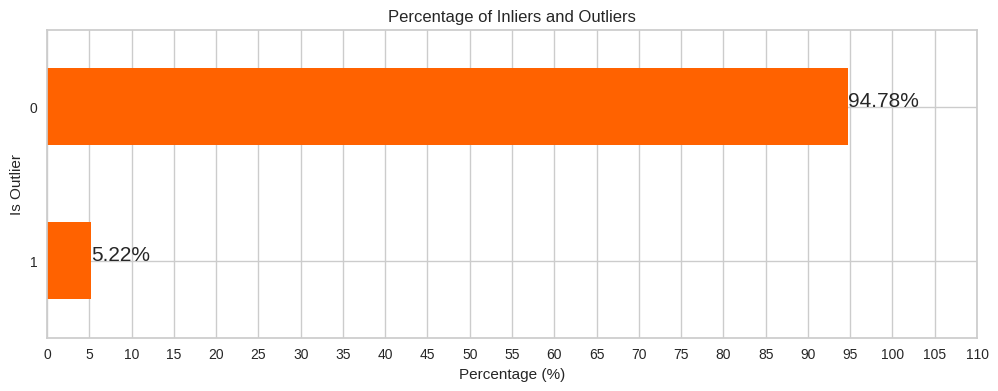

In [41]:
# Calculate the percentage of inliers and outliers
outlier_percentage = customer_data['Is_Outlier'].value_counts(normalize=True) * 100

# Plotting the percentage of inliers and outliers
plt.figure(figsize=(12, 4))
outlier_percentage.plot(kind='barh', color='#ff6200')

# Adding the percentage labels on the bars
for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

In [42]:
# Separate the outliers for analysis
outliers_data = customer_data[customer_data['Is_Outlier'] == 1]

# Remove the outliers from the main dataset
customer_data_cleaned = customer_data[customer_data['Is_Outlier'] == 0]

# Drop the 'Outlier_Scores' and 'Is_Outlier' columns
customer_data_cleaned = customer_data_cleaned.drop(columns=['Outlier_Scores', 'Is_Outlier'])

# Reset the index of the cleaned data
customer_data_cleaned.reset_index(drop=True, inplace=True)

In [43]:
# Getting the number of rows in the cleaned customer dataset
customer_data_cleaned.shape[0]

327

Step 6 | Correlation Analysis

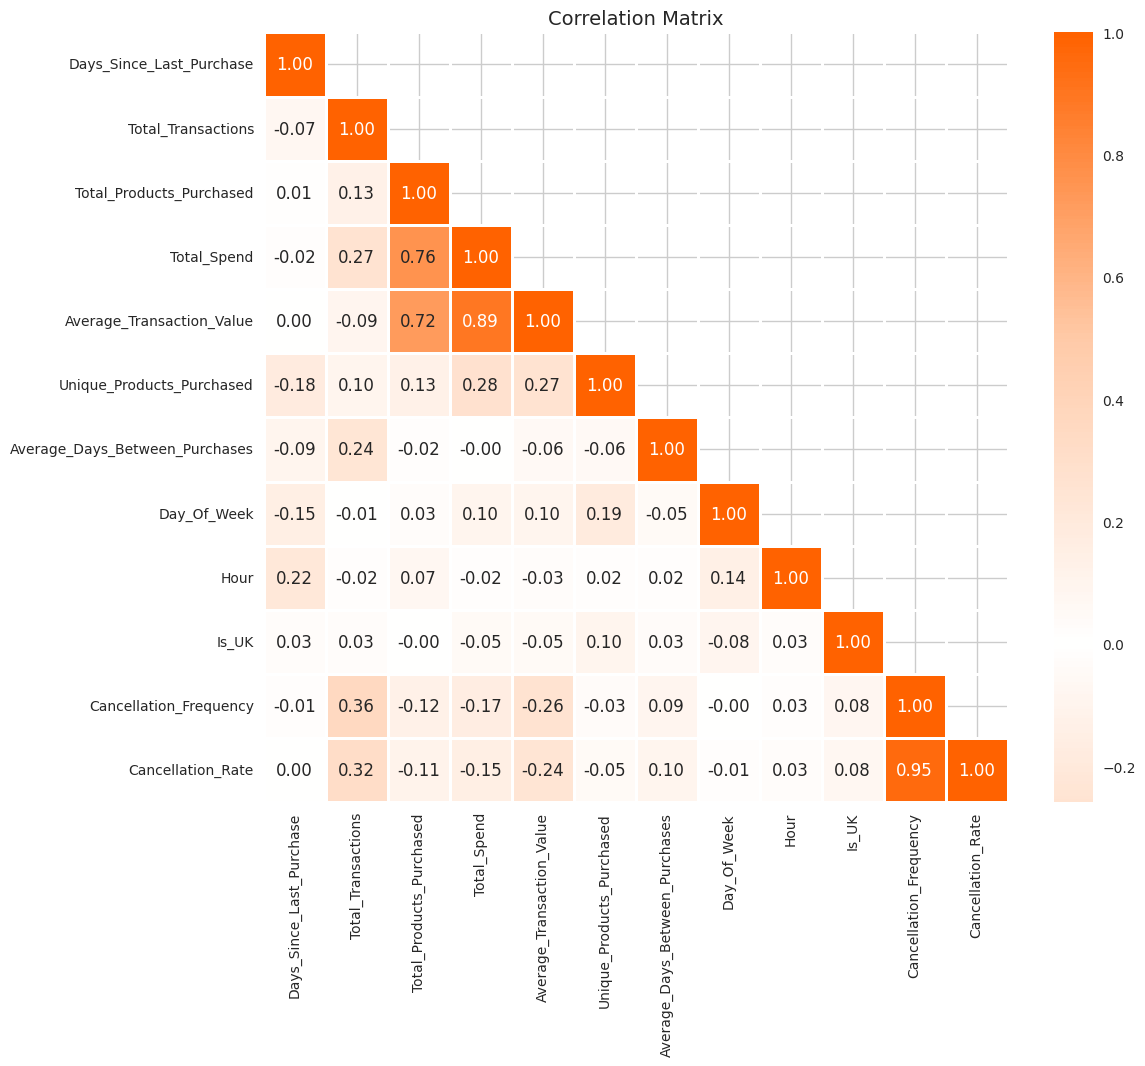

In [44]:
# Reset background style
sns.set_style('whitegrid')

# Calculate the correlation matrix excluding the 'CustomerID' column
corr = customer_data_cleaned.drop(columns=['CustomerID']).corr()

# Define a custom colormap
colors = ['#ff6200', '#ffcaa8', 'white', '#ffcaa8', '#ff6200']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

# Create a mask to only show the lower triangle of the matrix (since it's mirrored around its
# top-left to bottom-right diagonal)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

Step 7 | Feature Scaling

In [45]:
# Initialize the StandardScaler
scaler = StandardScaler()

# List of columns that don't need to be scaled
columns_to_exclude = ['CustomerID', 'Is_UK', 'Day_Of_Week']

# List of columns that need to be scaled
columns_to_scale = customer_data_cleaned.columns.difference(columns_to_exclude)

# Copy the cleaned dataset
customer_data_scaled = customer_data_cleaned.copy()

# Applying the scaler to the necessary columns in the dataset
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

# Display the first few rows of the scaled data
customer_data_scaled.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate
0,12395.0,0.055902,-0.400537,0.983889,-0.016338,0.133132,-0.502696,-0.113692,4,1.359028,0,-0.293903,-0.279862
1,12427.0,0.055902,-0.400537,-0.368165,-0.140097,-0.014453,-0.599963,-0.113692,4,-1.091719,0,-0.293903,-0.279862
2,12431.0,1.163782,-0.400537,-0.283850,0.018960,0.175225,-0.405429,-0.113692,2,-1.091719,0,-0.293903,-0.279862
3,12557.0,0.055902,-0.400537,0.598448,0.779380,1.082043,-0.843131,-0.113692,4,-0.274803,0,-0.293903,-0.279862
4,12567.0,-1.051977,-0.400537,1.233823,3.414108,4.224016,1.977618,-0.113692,6,-0.683261,0,-0.293903,-0.279862


Step 8 | Dimensionality Reduction

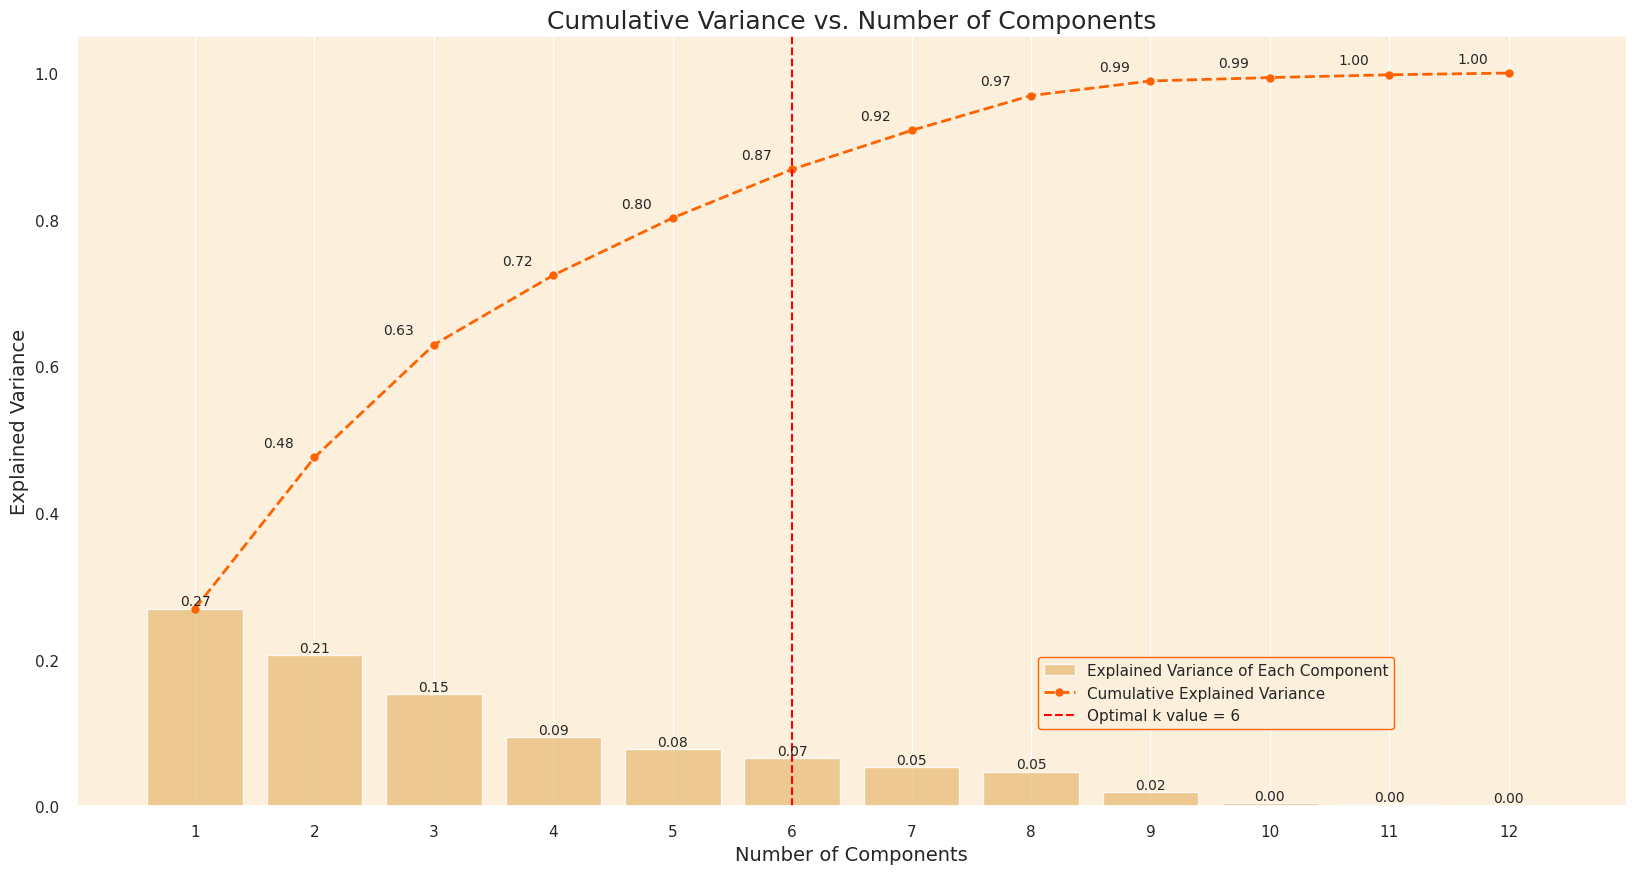

In [46]:
# Setting CustomerID as the index column
customer_data_scaled.set_index('CustomerID', inplace=True)

# Apply PCA
pca = PCA().fit(customer_data_scaled)

# Calculate the Cumulative Sum of the Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Set the optimal k value (based on our analysis, we can choose 6)
optimal_k = 6

# Set seaborn plot style
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

# Plot the cumulative explained variance against the number of components
plt.figure(figsize=(20, 10))

# Bar chart for the explained variance of each component
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y=explained_variance_ratio,
                      color='#fcc36d',
                      alpha=0.8)

# Line plot for the cumulative explained variance
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--', color='#ff6200', linewidth=2)

# Plot optimal k value line
optimal_k_line = plt.axvline(optimal_k - 1, color='red', linestyle='--', label=f'Optimal k value = {optimal_k}')

# Set labels and title
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

# Customize ticks and legend
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Optimal k value = {optimal_k}'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,
           edgecolor='#ff6200')

# Display the variance values for both graphs on the plots
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')
plt.show()

In [47]:
# Creating a PCA object with 6 components
pca = PCA(n_components=6)

# Fitting and transforming the original data to the new PCA dataframe
customer_data_pca = pca.fit_transform(customer_data_scaled)

# Creating a new dataframe from the PCA dataframe, with columns labeled PC1, PC2, etc.
customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# Adding the CustomerID index back to the new PCA dataframe
customer_data_pca.index = customer_data_scaled.index

In [48]:
# Displaying the resulting dataframe based on the PCs
customer_data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
CustomerID,,,,,,
12395.0,1.042353,0.265906,-0.382464,1.165054,0.491416,-0.016154
12427.0,0.559841,-0.338139,-0.812635,-0.476623,-0.209791,-1.151431
12431.0,-1.256310,0.636428,-0.581981,0.188044,-0.323459,-0.818750
12557.0,1.139604,0.976279,-0.151506,0.293253,-0.004320,-1.254113
12567.0,4.821368,3.613503,1.492465,-1.010972,-1.036616,-0.099493


Step 9 | K-Means Clustering

Step 9.1 | Determining the Optimal Number of Clusters

<div style="border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:120%; text-align:left">

To ascertain the optimal number of clusters (k) for segmenting customers, I will explore two renowned methods:

* __Elbow Method__

* __Silhouette Method__


Step 9.1.1 | Elbow Method

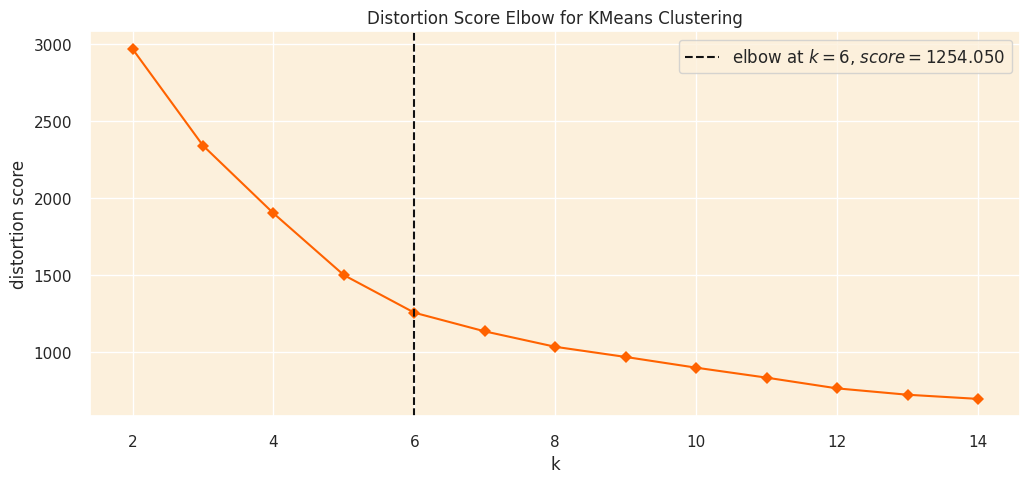

In [49]:
# Set plot style, and background color
sns.set(style='darkgrid', rc={'axes.facecolor': '#fcf0dc'})

# Set the color palette for the plot
sns.set_palette(['#ff6200'])

# Instantiate the clustering model with the specified parameters
km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)

# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(12, 5))

# Instantiate the KElbowVisualizer with the model and range of k values, and disable the timing plot
visualizer = KElbowVisualizer(km, k=(2, 15), timings=False, ax=ax)

# Fit the data to the visualizer
visualizer.fit(customer_data_pca)

# Finalize and render the figure
visualizer.show();


From the plot, we can see that the inertia continues to decrease significantly up to k=5, indicating that the optimum value of k could be between 3 and 7. To choose the best k within this range, we can employ the silhouette analysis

Step 9.2 | Clustering Model - K-means

<div style="border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:120%; text-align:left">

In this step, I am going to apply the K-means clustering algorithm to segment customers into different clusters based on their purchasing behaviors and other characteristics, using the optimal number of clusters determined in the previous step.

It's important to note that the K-means algorithm might assign different labels to the clusters in each run. To address this, we have taken an additional step to swap the labels based on the frequency of samples in each cluster, ensuring a consistent label assignment across different runs.

In [50]:
# Apply KMeans clustering using the optimal k
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(customer_data_pca)

# Get the frequency of each cluster
cluster_frequencies = Counter(kmeans.labels_)

# Create a mapping from old labels to new labels based on frequency
label_mapping = {label: new_label for new_label, (label, _) in
                 enumerate(cluster_frequencies.most_common())}

# Reverse the mapping to assign labels as per your criteria
label_mapping = {v: k for k, v in {2: 1, 1: 0, 0: 2}.items()}

# Apply the mapping to get the new labels
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

# Append the new cluster labels back to the original dataset
customer_data_cleaned['cluster'] = new_labels

# Append the new cluster labels to the PCA version of the dataset
customer_data_pca['cluster'] = new_labels

In [51]:
# Display the first few rows of the original dataframe
customer_data_cleaned.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,cluster
0,12395.0,3,1,528,346.1,346.1,12,0.0,4,16,0,0,0.0,2
1,12427.0,3,1,79,303.5,303.5,10,0.0,4,10,0,0,0.0,2
2,12431.0,5,1,107,358.25,358.25,14,0.0,2,10,0,0,0.0,2
3,12557.0,3,1,400,620.0,620.0,5,0.0,4,12,0,0,0.0,0
4,12567.0,1,1,611,1526.92,1526.92,63,0.0,6,11,0,0,0.0,0


Step 10 | Clustering Evaluation

Step 10.1 |  Cluster Distribution Visualization

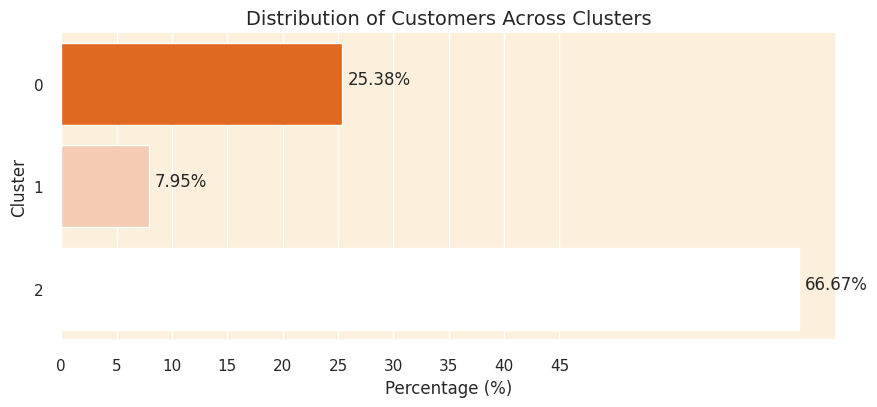

In [52]:
# Calculate the percentage of customers in each cluster
cluster_percentage = (customer_data_pca['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

# Create a horizontal bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

# Adding percentages on the bars
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

# Show the plot
plt.show()

Step 10.3 | Evaluation Metrics

In [53]:
# Compute number of customers
num_observations = len(customer_data_pca)

# Separate the features and the cluster labels
X = customer_data_pca.drop('cluster', axis=1)
clusters = customer_data_pca['cluster']

# Compute the metrics
sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

# Create a table to display the metrics and the number of observations
table_data = [
    ["Number of Observations", num_observations],
    ["Silhouette Score", sil_score],
    ["Calinski Harabasz Score", calinski_score],
    ["Davies Bouldin Score", davies_score]
]

# Print the table
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt='pretty'))

+-------------------------+---------------------+
|         Metric          |        Value        |
+-------------------------+---------------------+
| Number of Observations  |         327         |
|    Silhouette Score     | 0.37344618679868613 |
| Calinski Harabasz Score | 102.94297891009747  |
|  Davies Bouldin Score   |  1.167697173359146  |
+-------------------------+---------------------+


<h2 align="left"><font color='#ff6200'>Best Regards!</font></h2>